## The goal of this notebook is to predict the presence of kidney disease in the patient.
### Author: Abhisek Saha
#### Data: https://www.kaggle.com/mansoordaku/ckdisease


In [1]:
!ls

ChronicKidneyDiseasePrediction.ipynb  kidney_disease.csv


In [88]:
# Getting the dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Activation

In [3]:
df = pd.read_csv('kidney_disease.csv', index_col=0)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
id,,,,,,,,,,,,,,,,,,,,,
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
# the shape of the data
df.shape

(400, 25)

# EDA

In [5]:
# Getting information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [6]:
# Target variable value counts
df['classification'].value_counts()

ckd       248
notckd    150
ckd\t       2
Name: classification, dtype: int64

In [7]:
# Replacing ckd and notckd by 1 and 0
df['classification'] = df['classification'].replace('ckd',1)
df['classification'] = df['classification'].replace('ckd\t',1)
df['classification'] = df['classification'].replace('notckd',0)

### 1-> ckd
### 0-> notckd

In [8]:
df['classification'].value_counts()

1    250
0    150
Name: classification, dtype: int64

In [9]:
# Getting the correlation matrix
corr_mat = df.corr()

In [10]:
corr_mat['classification'].sort_values(ascending=False)

classification    1.000000
al                0.627090
bgr               0.419672
bu                0.380605
su                0.344070
sc                0.299969
bp                0.294077
age               0.227268
pot               0.084541
sod              -0.375674
sg               -0.732163
hemo             -0.768919
Name: classification, dtype: float64

### As the correlations are higher, we can not simply remove the features which have many missing values

In [11]:
# Checking null values
df.isnull().sum()

age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

# Dealing with Null values

In [12]:
# Drpping columns due to high number of missing values(>80)
df.drop(['rbc', 'wc', 'rc', 'pot', 'sod'], axis=1, inplace=True)

In [13]:
df['su'].value_counts(), df['su'].unique()

(0.0    290
 2.0     18
 3.0     14
 1.0     13
 4.0     13
 5.0      3
 Name: su, dtype: int64, array([ 0.,  3.,  4.,  1., nan,  2.,  5.]))

In [14]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,hemo,classification
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,348.000000,400.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,12.526437,0.625000
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,2.912587,0.484729
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,3.100000,0.000000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,10.300000,0.000000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,12.650000,1.000000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,15.000000,1.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,17.800000,1.000000


In [15]:
# Replacing missing values in numeric data types by the mean
def numeric_replace(feat):
    return feat.fillna(feat.mean(), inplace=True)

In [16]:
numeric_replace(df['age'])
numeric_replace(df['bp'])
numeric_replace(df['age'])
numeric_replace(df['bgr'])
numeric_replace(df['bu'])
numeric_replace(df['sc'])
numeric_replace(df['hemo'])

In [17]:
# replacing missing values of object data types by the mode value
def object_replace(feat):
    return feat.fillna(feat.value_counts().index[0], inplace=True)

In [18]:
object_replace(df['ane'])
object_replace(df['pe'])
object_replace(df['appet'])
object_replace(df['cad'])
object_replace(df['dm'])
object_replace(df['htn'])
object_replace(df['pcc'])
object_replace(df['ba'])
object_replace(df['pc'])

In [19]:
object_replace(df['sg'])
object_replace(df['al'])
object_replace(df['su'])

In [20]:
df['dm'].value_counts()

no       260
yes      134
\tno       3
\tyes      2
 yes       1
Name: dm, dtype: int64

In [21]:
df['dm'].unique()

array(['yes', 'no', ' yes', '\tno', '\tyes'], dtype=object)

#### As dm has ' yes', '\tno', '\tyes', we can replace them by yes or no

In [22]:
# replacing others values of dm by yes or no
df['dm'] = df['dm'].replace('\tno','no')
df['dm'] = df['dm'].replace('\tyes','yes')
df['dm'] = df['dm'].replace(' yes','yes')

In [23]:
# checking unique values in pcv
df['pcv'].unique()

array(['44', '38', '31', '32', '35', '39', '36', '33', '29', '28', nan,
       '16', '24', '37', '30', '34', '40', '45', '27', '48', '\t?', '52',
       '14', '22', '18', '42', '17', '46', '23', '19', '25', '41', '26',
       '15', '21', '43', '20', '\t43', '47', '9', '49', '50', '53', '51',
       '54'], dtype=object)

In [24]:
df['pcv'].value_counts()

41      21
52      21
48      19
44      19
40      16
43      14
45      13
42      13
36      12
32      12
28      12
50      12
33      12
34      11
37      11
29       9
30       9
35       9
46       9
31       8
39       7
24       7
26       6
38       5
49       4
47       4
54       4
53       4
51       4
27       3
22       3
25       3
19       2
23       2
17       1
\t?      1
21       1
15       1
14       1
9        1
\t43     1
16       1
20       1
18       1
Name: pcv, dtype: int64

In [25]:
# Replacing nan and other values in pcv
df['pcv'] = df['pcv'].replace('\t43',43)
df['pcv'] = df['pcv'].replace('\t?',df['pcv'].value_counts().index[0])
df['pcv'].fillna(df['pcv'].value_counts().index[0], inplace=True)
df['pcv'] = df['pcv'].astype(int)

In [26]:
df['cad'].value_counts()

no      364
yes      34
\tno      2
Name: cad, dtype: int64

In [27]:
df['cad'] = df['cad'].replace('\tno','no')

In [28]:
df.isnull().sum()

age               0
bp                0
sg                0
al                0
su                0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
hemo              0
pcv               0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

# Encoding categorical variables

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

/home/abhisek/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [30]:
df['pc'].value_counts()

normal      324
abnormal     76
Name: pc, dtype: int64

In [31]:
df['pc'] = le.fit_transform(df['pc'])

In [32]:
df['pc'].value_counts()

1    324
0     76
Name: pc, dtype: int64

In [33]:
cat_cols = ['ane', 'pe', 'appet', 'cad', 'dm', 'htn', 'ba', 'pcc', 'pc']

In [34]:
for cols in cat_cols:
    df[cols] = le.fit_transform(df[cols])

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   pc              400 non-null    int64  
 6   pcc             400 non-null    int64  
 7   ba              400 non-null    int64  
 8   bgr             400 non-null    float64
 9   bu              400 non-null    float64
 10  sc              400 non-null    float64
 11  hemo            400 non-null    float64
 12  pcv             400 non-null    int64  
 13  htn             400 non-null    int64  
 14  dm              400 non-null    int64  
 15  cad             400 non-null    int64  
 16  appet           400 non-null    int64  
 17  pe              400 non-null    int

In [36]:
# Again Checking correlation
corr_mat_all = df.corr()

In [37]:
corr_mat_all['classification'].sort_values(ascending=False)

classification    1.000000
htn               0.590438
dm                0.559060
al                0.531562
bgr               0.401374
appet             0.393341
pe                0.375154
bu                0.372033
ane               0.325396
su                0.294555
sc                0.294079
bp                0.290600
pcc               0.265313
cad               0.236088
age               0.225405
ba                0.186871
pc               -0.375154
pcv              -0.656471
sg               -0.659504
hemo             -0.729628
Name: classification, dtype: float64

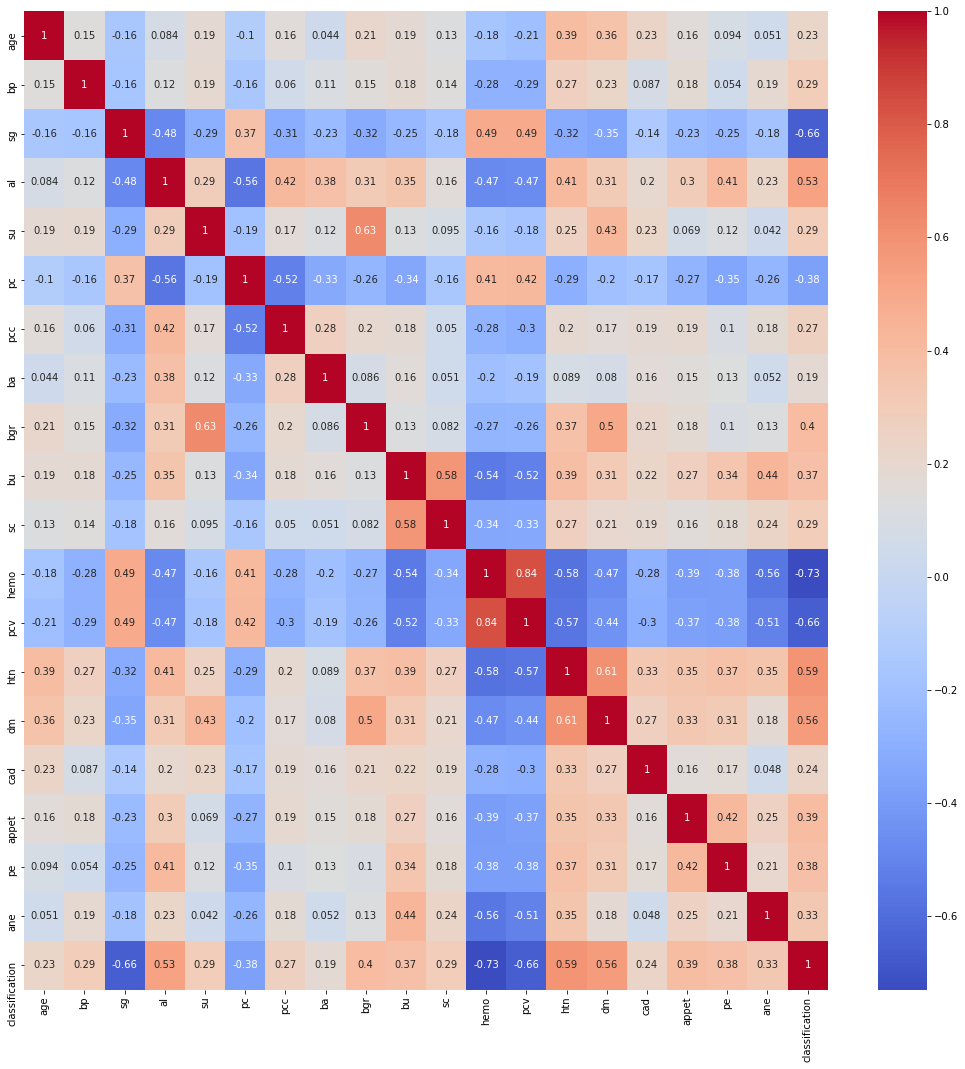

In [41]:
plt.figure(figsize=(18,18))
sns.heatmap(corr_mat_all, annot=True, cmap='coolwarm')
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [53]:
X = df.drop('classification', axis=1)
y = df['classification']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [60]:
print("The shape of X_train=", X_train.shape)
print("The shape of X_test =", X_test.shape)
print("The shape of y_train=", y_train.shape)
print("The shape of y_test =", y_test.shape)

The shape of X_train= (320, 19)
The shape of X_test = (80, 19)
The shape of y_train= (320,)
The shape of y_test = (80,)


In [61]:
# Normilize the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [62]:
models = []
Scores = {}
Names = []

models.append( ( 'LR', LogisticRegression() ))
models.append( ( 'KNN', KNeighborsClassifier() ))
models.append( ( 'DT', DecisionTreeClassifier() ))
models.append( ( 'RF', RandomForestClassifier() ))
models.append( ( 'ETR', ExtraTreesClassifier() ))
models.append( ( 'GBR', GradientBoostingClassifier() ))

for name, model in models:
    Names.append(name)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    Scores[name] = accuracy_score(y_test, pred)



In [63]:
Scores

{'LR': 0.9875,
 'KNN': 0.9625,
 'DT': 0.9875,
 'RF': 0.9875,
 'ETR': 1.0,
 'GBR': 0.9875}

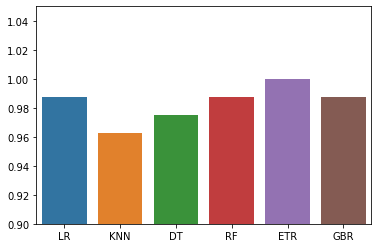

In [52]:
sns.barplot(x=list(Scores.keys()), y=list(Scores.values()) )
plt.ylim(0.9,)
plt.show()

In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

In [66]:
rf = RandomForestClassifier()
cross_val_score(rf, X, y, cv=10).mean()

0.9949999999999999

In [67]:
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
accuracy_score(y_test, pred_rf)

0.9875

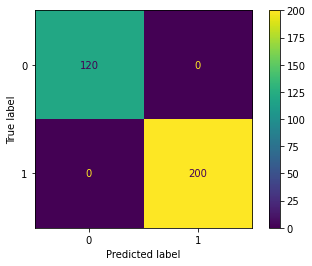

In [85]:
plot_confusion_matrix(rf, X_train, y_train)

In [58]:
# Save Model
import joblib

In [68]:
joblib.dump(rf, 'KidneyDiseasPredictor.pkl')

['KidneyDiseasPredictor.pkl']

In [69]:
model = joblib.load('KidneyDiseasPredictor.pkl')

In [82]:
model.predict(X_test[4].reshape(1,-1))

array([1])

In [77]:
y_test

id
287    0
149    1
22     1
325    0
113    1
      ..
19     1
130    1
345    0
293    0
72     1
Name: classification, Length: 80, dtype: int64

In [86]:
# Prediction using ANN

In [108]:
import keras as k
model = Sequential()

In [109]:
model.add(Dense(256, input_dim=19, kernel_initializer=k.initializers.random_normal(seed=13), activation='relu') )
model.add(Dense(1, activation='hard_sigmoid'))

In [110]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=X_train.shape[0])

Epoch 1/500
1/1 [==============================] - 1s 862ms/step - loss: 0.7304 - accuracy: 0.4406
Epoch 2/500
1/1 [==============================] - 0s 11ms/step - loss: 0.6939 - accuracy: 0.5531
Epoch 3/500
1/1 [==============================] - 0s 16ms/step - loss: 0.6597 - accuracy: 0.6469
Epoch 4/500
1/1 [==============================] - 0s 15ms/step - loss: 0.6276 - accuracy: 0.7281
Epoch 5/500
1/1 [==============================] - 0s 10ms/step - loss: 0.5973 - accuracy: 0.7688
Epoch 6/500
1/1 [==============================] - 0s 9ms/step - loss: 0.5685 - accuracy: 0.8031
Epoch 7/500
1/1 [==============================] - 0s 9ms/step - loss: 0.5412 - accuracy: 0.8094
Epoch 8/500
1/1 [==============================] - 0s 14ms/step - loss: 0.5152 - accuracy: 0.8125
Epoch 9/500
1/1 [==============================] - 0s 9ms/step - loss: 0.4905 - accuracy: 0.8344
Epoch 10/500
1/1 [==============================] - 0s 7ms/step - loss: 0.4672 - accuracy: 0.8344
Epoch 11/500
1/1 [====

1/1 [==============================] - 0s 13ms/step - loss: 0.0128 - accuracy: 1.0000
Epoch 167/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 168/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0126 - accuracy: 1.0000
Epoch 169/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 170/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0124 - accuracy: 1.0000
Epoch 171/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0123 - accuracy: 1.0000
Epoch 172/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0122 - accuracy: 1.0000
Epoch 173/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0121 - accuracy: 1.0000
Epoch 174/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0120 - accuracy: 1.0000
Epoch 175/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 1.0000
Epoch 176/500
1/1 [===

1/1 [==============================] - 0s 6ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 249/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 250/500
1/1 [==============================] - 0s 10ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 251/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 252/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 253/500
1/1 [==============================] - 0s 10ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 254/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 255/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 256/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 257/500
1/1 [==============================] - 0s 10ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 258/500
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 413/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 414/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 415/500
1/1 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 416/500
1/1 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 417/500
1/1 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 418/500
1/1 [==============================] - 0s 10ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 419/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 420/500
1/1 [==============================] - 0s 11ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 421/500
1/1 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 422/500
1/1

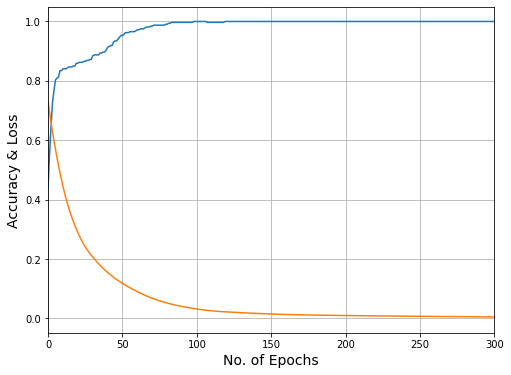

In [117]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlim(0,300)
plt.xlabel("No. of Epochs", fontsize=14)
plt.ylabel("Accuracy & Loss", fontsize=14)
plt.grid()
plt.show()